# Preprocessing

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np


# Load datasets from Kaggle
# Load each table separately
orders = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "olistbr/brazilian-ecommerce",
    "olist_orders_dataset.csv"
)

reviews = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "olistbr/brazilian-ecommerce",
    "olist_order_reviews_dataset.csv"
)

order_items = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "olistbr/brazilian-ecommerce",
    "olist_order_items_dataset.csv"
)

customers = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "olistbr/brazilian-ecommerce",
    "olist_customers_dataset.csv"
)

print(f"Loaded: Orders={len(orders)}, Reviews={len(reviews)}, Items={len(order_items)}, Customers={len(customers)}")

/tmp/ipython-input-2930743134.py:9: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  orders = kagglehub.load_dataset(


Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.


/tmp/ipython-input-2930743134.py:15: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  reviews = kagglehub.load_dataset(


100%|██████████| 6.42M/6.42M [00:00<00:00, 50.0MB/s]

Extracting zip of olist_order_reviews_dataset.csv...



/tmp/ipython-input-2930743134.py:21: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  order_items = kagglehub.load_dataset(


100%|██████████| 6.37M/6.37M [00:00<00:00, 151MB/s]

Extracting zip of olist_order_items_dataset.csv...



/tmp/ipython-input-2930743134.py:27: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  customers = kagglehub.load_dataset(


Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Loaded: Orders=99441, Reviews=99224, Items=112650, Customers=99441


In [ ]:
# Preview all the datasets
print("Customers: ", customers.head())
print("Orders: ", orders.head())
print("Reviews:", reviews.head())
print("Order Items: ", order_items.head())

Customers:                          customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
Orders:                             order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e761

In [ ]:
# Parse Timestamps
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at',
                  'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')
    print(orders[col].head())

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], errors='coerce')
print(reviews['review_creation_date'].head())

0   2017-10-02 10:56:33
1   2018-07-24 20:41:37
2   2018-08-08 08:38:49
3   2017-11-18 19:28:06
4   2018-02-13 21:18:39
Name: order_purchase_timestamp, dtype: datetime64[ns]
0   2017-10-02 11:07:15
1   2018-07-26 03:24:27
2   2018-08-08 08:55:23
3   2017-11-18 19:45:59
4   2018-02-13 22:20:29
Name: order_approved_at, dtype: datetime64[ns]
0   2017-10-04 19:55:00
1   2018-07-26 14:31:00
2   2018-08-08 13:50:00
3   2017-11-22 13:39:59
4   2018-02-14 19:46:34
Name: order_delivered_carrier_date, dtype: datetime64[ns]
0   2017-10-10 21:25:13
1   2018-08-07 15:27:45
2   2018-08-17 18:06:29
3   2017-12-02 00:28:42
4   2018-02-16 18:17:02
Name: order_delivered_customer_date, dtype: datetime64[ns]
0   2017-10-18
1   2018-08-13
2   2018-09-04
3   2017-12-15
4   2018-02-26
Name: order_estimated_delivery_date, dtype: datetime64[ns]
0   2018-01-18
1   2018-03-10
2   2018-02-17
3   2017-04-21
4   2018-03-01
Name: review_creation_date, dtype: datetime64[ns]


In [ ]:
# Create Intervention Variable
orders['delivery_delay_days'] = (
    orders['order_delivered_customer_date'] -
    orders['order_estimated_delivery_date']
).dt.total_seconds() / (24 * 3600)

orders['delayed_delivery'] = (orders['delivery_delay_days'] > 0).astype(int)
print(orders['delayed_delivery'].head())
print(orders['delayed_delivery'].value_counts())


0    0
1    0
2    0
3    0
4    0
Name: delayed_delivery, dtype: int64
delayed_delivery
0    91614
1     7827
Name: count, dtype: int64


In [ ]:
# Outcome Variable
reviews_clean = reviews[['order_id', 'review_score']].drop_duplicates(
    subset='order_id', keep='first'
)
orders = orders.merge(reviews_clean, on='order_id', how='inner')
print(orders.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15

In [ ]:
# Computing Order Level Features
order_agg = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
    'order_item_id': 'count'
}).reset_index()
order_agg.columns = ['order_id', 'order_price', 'freight_value', 'num_items']

orders = orders.merge(order_agg, on='order_id', how='left')
orders[['order_price', 'freight_value', 'num_items']] = orders[[
    'order_price', 'freight_value', 'num_items'
]].fillna(0)

In [ ]:
# Compute Customer History
orders = orders.merge(
    customers[['customer_id', 'customer_unique_id']],
    on='customer_id', how='left'
)
orders = orders.sort_values(['customer_unique_id', 'order_purchase_timestamp'])

orders['customer_first_order'] = orders.groupby('customer_unique_id')[
    'order_purchase_timestamp'
].transform('min')
orders['customer_tenure_days'] = (
    orders['order_purchase_timestamp'] - orders['customer_first_order']
).dt.total_seconds() / (24 * 3600)

orders['prior_orders'] = orders.groupby('customer_unique_id').cumcount()
orders['is_first_order'] = (orders['prior_orders'] == 0).astype(int)

In [ ]:
# Data Validation
df_clean = orders[
    orders['order_delivered_customer_date'].notna() &
    orders['order_estimated_delivery_date'].notna() &
    orders['review_score'].notna() &
    (orders['order_status'] == 'delivered')
].copy()

In [ ]:
final_cols = [
    'order_id', 'customer_unique_id',
    'delayed_delivery', 'delivery_delay_days',
    'review_score',
    'order_price', 'freight_value', 'num_items',
    'customer_tenure_days', 'prior_orders', 'is_first_order',
    'order_purchase_timestamp', 'order_delivered_customer_date'
]

df_final = df_clean[final_cols].reset_index(drop=True)
df_final.to_csv('olist_preprocessed_causal.csv', index=False)

# Causal Discovery

In [ ]:
!pip install causal-learn gCastle

In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.cit import fisherz
from castle.algorithms import Notears

In [ ]:
# Load data
df = pd.read_csv('olist_preprocessed_causal.csv')

print(f"Loaded dataset: {df.shape}")
print(f"Treatment: delayed_delivery")
print(f"Outcome: review_score")

Loaded dataset: (95824, 13)
Treatment: delayed_delivery
Outcome: review_score


In [ ]:
# Prepare data for Causal Algorithms
causal_vars = [
    'delayed_delivery',
    'review_score',
    'order_price',
    'freight_value',
    'num_items',
    'customer_tenure_days',
    'prior_orders',
    'is_first_order'
]

# Sample for computational efficiency
np.random.seed(42)
sample_size = min(10000, len(df))
df_sample = df[causal_vars].sample(n=sample_size, random_state=42).reset_index(drop=True)

# Standardize for numerical stability
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_sample)
data_scaled_df = pd.DataFrame(data_scaled, columns=causal_vars)

print(f"\nCausal discovery dataset: {data_scaled_df.shape}")
print(f"Variables: {causal_vars}\n")


Causal discovery dataset: (10000, 8)
Variables: ['delayed_delivery', 'review_score', 'order_price', 'freight_value', 'num_items', 'customer_tenure_days', 'prior_orders', 'is_first_order']



In [ ]:
# Running of Causal Discovery Algorithms

# Algorithm 1: PC (Constraint-Based)
cg_pc = pc(data_scaled_df.values, alpha=0.05, indep_test=fisherz)
edges_pc = set()
G_pc = cg_pc.G.graph
for i in range(len(causal_vars)):
    for j in range(len(causal_vars)):
        if G_pc[i, j] == -1 and G_pc[j, i] == 1:  # i -> j
            edges_pc.add((causal_vars[i], causal_vars[j]))
        elif G_pc[i, j] == 1 and G_pc[j, i] == -1:  # j -> i
            edges_pc.add((causal_vars[j], causal_vars[i]))
        elif G_pc[i, j] == -1 and G_pc[j, i] == -1:  # undirected
            edges_pc.add((causal_vars[i], causal_vars[j]))

print(f"PC found {len(edges_pc)} edges")

# Algorithm 2: GES (Score-Based)
record_ges = ges(data_scaled_df.values, score_func='local_score_BIC')
edges_ges = set()
G_ges = record_ges['G'].graph
for i in range(len(causal_vars)):
    for j in range(len(causal_vars)):
        if G_ges[i, j] == -1 and G_ges[j, i] == 1:  # i -> j
            edges_ges.add((causal_vars[i], causal_vars[j]))
        elif G_ges[i, j] == 1 and G_ges[j, i] == -1:  # j -> i
            edges_ges.add((causal_vars[j], causal_vars[i]))


print(f"GES found {len(edges_ges)} edges")

# Algorithm 3: NOTEARS (via gCastle)
notears = Notears()
notears.learn(data_scaled_df.values)
causal_matrix = notears.causal_matrix

# Extract edges from causal matrix (threshold for weak connections)
edges_notears = set()
threshold = 0.3
for i in range(len(causal_vars)):
    for j in range(len(causal_vars)):
        if abs(causal_matrix[i, j]) > threshold:
            edges_notears.add((causal_vars[i], causal_vars[j]))

print(f"NOTEARS found {len(edges_notears)} edges\n")

  0%|          | 0/8 [00:00<?, ?it/s]

PC found 14 edges
GES found 2 edges
NOTEARS found 4 edges



In [ ]:
# Building a Consensus DAG

# Count algorithm votes for each edge
edge_votes = {}
all_edges = edges_pc | edges_ges | edges_notears

for edge in all_edges:
    votes = 0
    if edge in edges_pc or (edge[1], edge[0]) in edges_pc:
        votes += 1
    if edge in edges_ges or (edge[1], edge[0]) in edges_ges:
        votes += 1
    if edge in edges_notears:
        votes += 1
    edge_votes[edge] = votes

# Keep edges with ≥2 votes (conservative consensus)
consensus_threshold = 2
consensus_edges = [(u, v) for (u, v), votes in edge_votes.items() if votes >= consensus_threshold]

print(f"Consensus edges (≥{consensus_threshold} algorithms agree): {len(consensus_edges)}")

Consensus edges (≥2 algorithms agree): 6


In [ ]:
# Enforcing Temporal Constraints

pre_treatment = ['order_price', 'freight_value', 'num_items',
                 'customer_tenure_days', 'prior_orders', 'is_first_order']
treatment = ['delayed_delivery']
outcome = ['review_score']

valid_edges = []
for u, v in consensus_edges:
    # Pre-treatment → treatment
    if u in pre_treatment and v in treatment:
        valid_edges.append((u, v))
    # Pre-treatment → outcome
    elif u in pre_treatment and v in outcome:
        valid_edges.append((u, v))
    # Treatment → outcome
    elif u in treatment and v in outcome:
        valid_edges.append((u, v))
    # Pre-treatment → pre-treatment
    elif u in pre_treatment and v in pre_treatment:
        valid_edges.append((u, v))

print(f"Valid edges after temporal filtering: {len(valid_edges)}")

Valid edges after temporal filtering: 6


In [ ]:
G_consensus = nx.DiGraph()
G_consensus.add_nodes_from(causal_vars)
G_consensus.add_edges_from(valid_edges)

In [ ]:
# Addition of domain knowledge to causal outputs

domain_knowledge_edges = [
    ('order_price', 'delayed_delivery'),
    ('prior_orders', 'delayed_delivery'),
    ('is_first_order', 'delayed_delivery')
]

# Add edges
for edge in domain_knowledge_edges:
    print(f"Adding: {edge[0]} → {edge[1]}")
    valid_edges.append(edge)
    G_consensus.add_edge(edge[0], edge[1])

problematic_edges = [
    ('is_first_order', 'prior_orders')  # Wrong: prior_orders determines is_first_order, not vice versa
]

for edge in problematic_edges:
    if G_consensus.has_edge(edge[0], edge[1]):
        print(f"Removing: {edge[0]} → {edge[1]} (wrong causal direction)")
        G_consensus.remove_edge(edge[0], edge[1])
        if edge in valid_edges:
            valid_edges.remove(edge)

Adding: order_price → delayed_delivery
Adding: prior_orders → delayed_delivery
Adding: is_first_order → delayed_delivery
Removing: is_first_order → prior_orders (wrong causal direction)


In [ ]:
# Creating the final DAG

print(f"\nFinal consensus DAG:")
print(f"Nodes: {len(G_consensus.nodes)}")
print(f"Edges: {len(G_consensus.edges)}")
print(f"\nEdges:")
for u, v in G_consensus.edges():
    print(f"  {u} → {v}")


Final consensus DAG:
Nodes: 8
Edges: 8

Edges:
  delayed_delivery → review_score
  order_price → delayed_delivery
  freight_value → num_items
  freight_value → order_price
  num_items → review_score
  customer_tenure_days → is_first_order
  prior_orders → delayed_delivery
  is_first_order → delayed_delivery


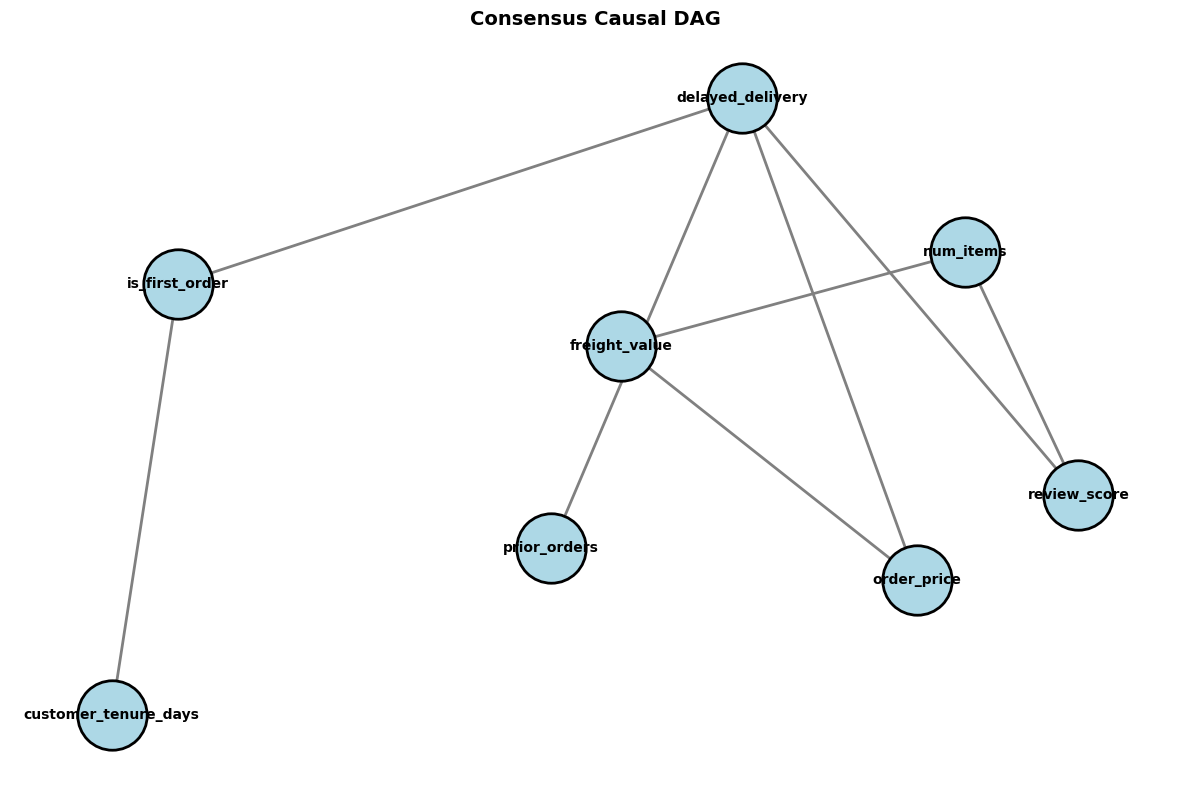

In [ ]:
# Visual Representation of DAG

G = nx.DiGraph(valid_edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='lightblue', edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=2)

plt.title('Consensus Causal DAG', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('dag.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Adjustment Set Identification

treatment_var = 'delayed_delivery'
outcome_var = 'review_score'

# Find parents of treatment (confounders)
parents_of_treatment = list(G_consensus.predecessors(treatment_var))
print(f"\nParents of {treatment_var}: {parents_of_treatment}")

# Build adjustment set
adjustment_set = set(parents_of_treatment)

# Add parents of outcome that are pre-treatment
parents_of_outcome = list(G_consensus.predecessors(outcome_var))
for parent in parents_of_outcome:
    if parent in pre_treatment:
        adjustment_set.add(parent)

adjustment_set = list(adjustment_set)
print(f"\nRecommended adjustment set for causal estimation:")
print(f"  {adjustment_set}")


Parents of delayed_delivery: ['order_price', 'prior_orders', 'is_first_order']

Recommended adjustment set for causal estimation:
  ['order_price', 'num_items', 'prior_orders', 'is_first_order']


In [ ]:
edges_df = pd.DataFrame(valid_edges, columns=['from', 'to'])
edges_df.to_csv('causal_dag_edges.csv', index=False)

with open('adjustment_set.txt', 'w') as f:
    f.write(','.join(adjustment_set))

print(f"\n DAG edges saved to: causal_dag_edges.csv")
print(f"Adjustment set saved to: adjustment_set.txt")


 DAG edges saved to: causal_dag_edges.csv
Adjustment set saved to: adjustment_set.txt


# Causal Effect Estimation

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Loading previous data

df = pd.read_csv('olist_preprocessed_causal.csv')
print(f"Dataset: {df.shape}")
with open('adjustment_set.txt', 'r') as f:
    adjustment_set = f.read().strip().split(',')

print(f"\nAdjustment set from DAG: {adjustment_set}")

Dataset: (95824, 13)

Adjustment set from DAG: ['order_price', 'num_items', 'prior_orders', 'is_first_order']


In [ ]:
# Baseline Analysis (Non Causal)
# Biased method, problematic

delayed = df[df['delayed_delivery'] == 1]['review_score'].mean()
on_time = df[df['delayed_delivery'] == 0]['review_score'].mean()
naive_effect = delayed - on_time

print(f"\nMean review score:")
print(f"  Delayed orders: {delayed:.3f}")
print(f"  On-time orders: {on_time:.3f}")
print(f"  Naive difference: {naive_effect:.3f}")

# Naive regression (no adjustment)
naive_model = smf.ols('review_score ~ delayed_delivery', data=df).fit()
print(f"\nNaive regression (no confounders):")
print(f"  Effect: {naive_model.params['delayed_delivery']:.3f}")
print(f"  95% CI: [{naive_model.conf_int().loc['delayed_delivery', 0]:.3f}, "
      f"{naive_model.conf_int().loc['delayed_delivery', 1]:.3f}]")
print(f"  p-value: {naive_model.pvalues['delayed_delivery']:.4f}")


Mean review score:
  Delayed orders: 2.565
  On-time orders: 4.294
  Naive difference: -1.729

Naive regression (no confounders):
  Effect: -1.729
  95% CI: [-1.757, -1.701]
  p-value: 0.0000


In [ ]:
# Method 1: Regression Adjustment

formula = 'review_score ~ delayed_delivery'
for var in adjustment_set:
    if var in df.columns and var not in ['delayed_delivery', 'review_score']:
        formula += f' + {var}'

print(f"\nFormula: {formula}")

# Fit adjusted regression
adjusted_model = smf.ols(formula, data=df).fit()

print(f"\nAdjusted causal effect:")
print(f"  Effect: {adjusted_model.params['delayed_delivery']:.3f}")
print(f"  95% CI: [{adjusted_model.conf_int().loc['delayed_delivery', 0]:.3f}, "
      f"{adjusted_model.conf_int().loc['delayed_delivery', 1]:.3f}]")
print(f"  p-value: {adjusted_model.pvalues['delayed_delivery']:.4f}")
print(f"  R²: {adjusted_model.rsquared:.3f}")


Formula: review_score ~ delayed_delivery + order_price + num_items + prior_orders + is_first_order

Adjusted causal effect:
  Effect: -1.738
  95% CI: [-1.765, -1.710]
  p-value: 0.0000
  R²: 0.150


In [ ]:
# Method 2: Propensity Score Weighting

# Prepare features for propensity model
X_vars = [var for var in adjustment_set if var in df.columns and var not in ['delayed_delivery', 'review_score']]
X = df[X_vars].fillna(df[X_vars].mean())
y_treatment = df['delayed_delivery']

# Estimate propensity scores
propensity_model = LogisticRegression(max_iter=1000, random_state=42)
propensity_model.fit(X, y_treatment)
propensity_scores = propensity_model.predict_proba(X)[:, 1]

# Clip propensity scores to avoid extreme weights
propensity_scores = np.clip(propensity_scores, 0.01, 0.99)

# Compute IPW weights
weights = np.where(
    df['delayed_delivery'] == 1,
    1 / propensity_scores,
    1 / (1 - propensity_scores)
)

# Weighted mean difference
weighted_delayed = np.average(
    df[df['delayed_delivery'] == 1]['review_score'],
    weights=weights[df['delayed_delivery'] == 1]
)
weighted_on_time = np.average(
    df[df['delayed_delivery'] == 0]['review_score'],
    weights=weights[df['delayed_delivery'] == 0]
)
ipw_effect = weighted_delayed - weighted_on_time

print(f"\nPropensity score distribution:")
print(f"  Mean: {propensity_scores.mean():.3f}")
print(f"  Min: {propensity_scores.min():.3f}")
print(f"  Max: {propensity_scores.max():.3f}")

print(f"\nIPW causal effect:")
print(f"  Effect: {ipw_effect:.3f}")


Propensity score distribution:
  Mean: 0.080
  Min: 0.010
  Max: 0.457

IPW causal effect:
  Effect: -1.729


In [ ]:
# Method 3: Matching

# Prepare data for matching
X_match = df[X_vars].fillna(df[X_vars].mean()).values
treated = df[df['delayed_delivery'] == 1].index
control = df[df['delayed_delivery'] == 0].index

# Match each treated unit to nearest control
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(X_match[control])

distances, indices = nn.kneighbors(X_match[treated])
matched_control_indices = control[indices.flatten()]

# Compute matched effect
treated_outcomes = df.loc[treated, 'review_score'].values
matched_control_outcomes = df.loc[matched_control_indices, 'review_score'].values
matching_effect = (treated_outcomes - matched_control_outcomes).mean()

print(f"\nMatching statistics:")
print(f"  Treated units: {len(treated)}")
print(f"  Matched pairs: {len(matched_control_indices)}")
print(f"  Avg matching distance: {distances.mean():.3f}")

print(f"\nMatching causal effect:")
print(f"  Effect: {matching_effect:.3f}")


Matching statistics:
  Treated units: 7661
  Matched pairs: 7661
  Avg matching distance: 0.029

Matching causal effect:
  Effect: -1.752


In [ ]:
results = pd.DataFrame({
    'Method': [
        'Naive (Biased)',
        'Regression Adjustment',
        'Propensity Score Weighting',
        'Matching'
    ],
    'Effect': [
        naive_effect,
        adjusted_model.params['delayed_delivery'],
        ipw_effect,
        matching_effect
    ]
})

print(f"\n{results.to_string(index=False)}")

print(f"\n Interpretation:")
print(f"  - Naive estimate: {naive_effect:.3f} (BIASED)")
print(f"  - Causal estimates: {adjusted_model.params['delayed_delivery']:.3f} to {matching_effect:.3f}")
print(f"  - Difference from naive: {abs(naive_effect - adjusted_model.params['delayed_delivery']):.3f} points")


                    Method    Effect
            Naive (Biased) -1.729039
     Regression Adjustment -1.737702
Propensity Score Weighting -1.729321
                  Matching -1.752382

 Interpretation:
  - Naive estimate: -1.729 (BIASED)
  - Causal estimates: -1.738 to -1.752
  - Difference from naive: 0.009 points


# Heterogeneous Effects

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_csv('olist_preprocessed_causal.csv')

In [ ]:
# First time vs Repeat Customers

print("\nEffect by Customer Type:")

for is_first in [0, 1]:
    subset = df[df['is_first_order'] == is_first]
    label = "First-time" if is_first == 1 else "Repeat"

    delayed = subset[subset['delayed_delivery'] == 1]['review_score'].mean()
    ontime = subset[subset['delayed_delivery'] == 0]['review_score'].mean()
    effect = delayed - ontime

    print(f"  {label}: {effect:.3f} (N={len(subset)})")


Effect by Customer Type:
  Repeat: -1.586 (N=3175)
  First-time: -1.733 (N=92649)


In [ ]:
# Order Value

df['order_category'] = pd.qcut(df['order_price'], q=3, labels=['Low', 'Medium', 'High'])

print("\nEffect by Order Value:")

for category in ['Low', 'Medium', 'High']:
    subset = df[df['order_category'] == category]

    delayed = subset[subset['delayed_delivery'] == 1]['review_score'].mean()
    ontime = subset[subset['delayed_delivery'] == 0]['review_score'].mean()
    effect = delayed - ontime

    print(f"  {category}: {effect:.3f} (N={len(subset)})")


Effect by Order Value:
  Low: -1.686 (N=32301)
  Medium: -1.709 (N=31602)
  High: -1.777 (N=31921)


In [ ]:
# Interaction Test

interaction_model = smf.ols('review_score ~ delayed_delivery * is_first_order', data=df).fit()
interaction_effect = interaction_model.params.get('delayed_delivery:is_first_order', 0)

print(f"\nInteraction (delay × first-time): {interaction_effect:.3f}")
print(f"  Significant: {'Yes' if interaction_model.pvalues.get('delayed_delivery:is_first_order', 1) < 0.05 else 'No'}")



Interaction (delay × first-time): -0.147
  Significant: No
